In [31]:


from PIL import Image

import os
from os.path import split,join, isdir ,exists
os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
from loguru import logger
import torch
import numpy as np
import skimage
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image

from utils import *
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

from dataloaders.datasets.nyud3 import Nyud3

from plot.plot_utils import *

from utils import * 



In [58]:







class NyudV2QualitativeSelector:

    def __init__(self,root,name,save_dir = None ,dataset =None):


        if dataset is None :
            self.dataset = Nyud3()
        else:
            self.dataset = dataset


        if save_dir is None : 
            self.save_dir = join('logs/nyudv2',name)
        else:
            self.save_dir = save_dir

        make_dir(self.save_dir)

        self.root = root
        self.name  = name

        self.name_list = np.loadtxt('data/nyud2/NYU_origin/depth_normal_edges_3x3/range123/matlab_load_sequence.txt',dtype=np.str0)

        self.COLORS = {
            "TP":(20,255,10),
            "FN":(255,10,10),
            "FP":(251,254,3),
        }
    
        #* load performance of each task for each image 
        self.TASKS = ["reflectance","illumination","normal","depth","all_edges"]
        self.normal  =self.get_images_quantitative_results('normal')
        self.depth  =self.get_images_quantitative_results('depth')
    
    def __len__(self):
        return  len(self.name_list)
    


    def get_task_best_image(self,task):
        ans = {}

        for idx in range(self.__len__()):

            
            ans[self.name_list[idx]] = self.get_task_F_quantitatives(task,idx)

        return  sorted(ans.items(), key =lambda k : k[1])[::-1]
        
    
    def get_name(self):
        return self.name

    def get_images_quantitative_results(self,task):
        
        assert task in self.TASKS
        # return np.loadtxt(join(self.root,task,'nms-eval','eval_bdry_img.txt'),dtype=np.str0)[idx]
        return np.loadtxt(join(self.root,task,'nms-eval','eval_bdry_img.txt'))

    
    def getitem_by_task(self,task,idx):

        name = self.name_list[idx]

        image,label,edge,depth_map,depth_edge,normal_map,normal_edge,__  = self.dataset.getitem_by_name(name+'.png')

        image = image[45:471, 41:601]
        depth_edge = depth_edge[45:471, 41:601]
        normal_edge = normal_edge[45:471, 41:601]

        prediction_edge  = imread(join(self.root,task,'nms',self.name_list[idx]+'.png'),gray=True)
        
        if task == 'normal':
            return image,normal_edge,prediction_edge,name
        elif task == 'depth' :
            return image,depth_edge,prediction_edge,name


    def get_quantitatives(self,index):
        
        name = self.name_list[index]
        # reflectance =self.reflectance[index]
        # illumination = self.illumination[index]
        normal =self.normal[index]
        depth = self.depth[index]

        return normal,depth,name
    
    def get_F_quantitatives(self,index):
        name = self.name_list[index]
        # reflectance =self.reflectance[index][-1]
        # illumination = self.illumination[index][-1]
        normal =self.normal[index][-1]
        depth = self.depth[index][-1]
        return normal,depth,name

    
        
    def get_task_F_quantitatives(self,task,index):
        return getattr(self,task)[index][-1],self.name_list[index]

    def name2idx(self,name):
        
        return np.where(self.name_list == name)[0][0]

    def draw_edge(self,task,idx,threshold_range = np.arange(0.5,1,0.1)):


        image,gt_edge, prediction_edge,name = self.getitem_by_task(task,idx)#* 0-255 map 


        
        # print(f'gt edge :{np.unique(gt_edge)}, image.shape : {image.shape }, gt_edge : {gt_edge.shape},prediction_edge: {prediction_edge.shape} ')

        gt_edge = gt_edge/255
        
        name_format = "%s_%d.png"
        save_dir = join(self.save_dir,task)
        make_dir(save_dir)

        ans=[]
        for threshold in threshold_range:

            
            save_name = join(save_dir, name_format%(name,threshold*100))
            
            # if exists(save_name):
            #     return [imread(save_name)[:,:,::-1]]

            image_drawed = image.copy()[:,:,::-1]

            filter_pred_edge = (prediction_edge>threshold*255)

            #* FP
            image_drawed [(gt_edge==0) & ( filter_pred_edge ==1)] = self.COLORS['FP']

            #* FN
            image_drawed[(gt_edge==1)  &  (filter_pred_edge ==0)] = self.COLORS['FN']

            # print(f'before {(filter_pred_edge==1).sum()}')
            dilation_times  = 3
            # show_imgs([filter_pred_edge],[0])
            # logger.info(f"dilation times == {dilation_times}")
            filter_pred_edge = dilation(filter_pred_edge,times=dilation_times)/255
            # show_imgs([filter_pred_edge],[0])
            
            # print(f'after {(filter_pred_edge==1).sum()}')
            #* TP
            image_drawed[(gt_edge == 1 ) &  (filter_pred_edge==1)] = self.COLORS['TP']

            show_imgs([image_drawed],[0],img_name=save_name)

            ans.append(image_drawed)


        return ans
            

     
    





RINDNET_ROOT="/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/run_NYUD2"

dataset = Nyud3()


our_drawer = NyudV2QualitativeSelector('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/nyud2_1','ours',dataset= dataset)
# our_drawer.draw_edge('normal',0)
# our_drawer.get_task_F_quantitatives('normal',0)
# our_drawer.get_F_quantitatives(0)

  
hed_selector = NyudV2QualitativeSelector(join(RINDNET_ROOT,'hed'),'hed',dataset=dataset)
dff_selector = NyudV2QualitativeSelector(join(RINDNET_ROOT,'dff'),'dff',dataset=dataset)
rcf_selector = NyudV2QualitativeSelector(join(RINDNET_ROOT,'rcf'),'rcf',dataset=dataset)
rindnet_selector = NyudV2QualitativeSelector(join(RINDNET_ROOT,'rindnet'),'rindnet',dataset=dataset)





In [59]:

def get_best_image(main_drawer,other_drawer_list,task = 'reflectance'):

    n =  len(other_drawer_list)

    distance_dict = {}
    
    for index in range(main_drawer.__len__()):

        main_f, name  = main_drawer.get_task_F_quantitatives(task,index)
        distance = 0 


        for d in other_drawer_list:
            distance += (main_f - d.get_task_F_quantitatives(task,index)[0])

        
        distance_dict[name] = distance/n

    
    return  sorted(distance_dict.items(), key =lambda k : k[1])[::-1]

    

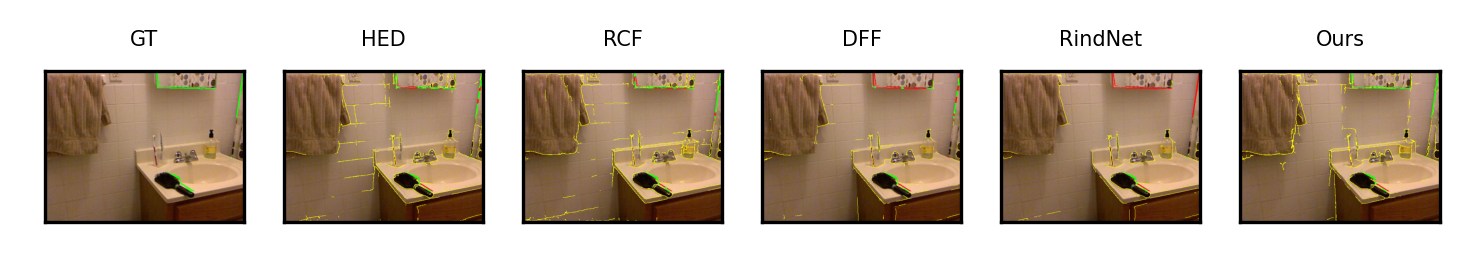

In [62]:
# dataset = Nyud3()
# dataset.getitem_by_name('1.png')



for task in ['normal','depth']:
# for task in ['normal']:

    best_dict = get_best_image(our_drawer,[hed_selector,rcf_selector,dff_selector,rindnet_selector],task)

    compare_save_path = 'logs/nyudv2/compare/%s'%(task)
    gt_save_path = 'logs/nyudv2/gt/%s'%(task)
    make_dir(compare_save_path)
    make_dir(gt_save_path)

    # compare_save_path

    threshold_range = [0.5]


    for name in [x[0] for x in best_dict][:30]:
        
        save_path = join(compare_save_path,name+'.png')
        if exists(save_path):
            continue

        idx = our_drawer.name2idx(name)
        image,gt_edge,prediction_edge,name = our_drawer.getitem_by_task(task,idx)
        gt_edge = gt_edge/255
        
        draw_image = image[:,:,::-1].copy()

        draw_image[gt_edge==1] = our_drawer.COLORS['TP']
        show_imgs([draw_image],[0],img_name=join(gt_save_path,name+'.png'))

        
        __ours = our_drawer.draw_edge(task,idx,threshold_range)
        __hed = hed_selector.draw_edge(task,idx,threshold_range)
        __dff = dff_selector.draw_edge(task,idx,threshold_range)
        __rcf = rcf_selector.draw_edge(task,idx,threshold_range)
        __rindnet = rindnet_selector.draw_edge(task,idx,threshold_range)

        
        image_list = [draw_image] +__hed+__rcf+__dff+__rindnet + __ours

        show_imgs(image_list,[0]*len(image_list),titles=['GT','HED','RCF','DFF','RindNet','Ours'],img_name=save_path)

    
    

[('270', 0.10239025),
 ('1147', 0.10182799999999997),
 ('1146', 0.10032924999999998),
 ('1094', 0.09933250000000002),
 ('1174', 0.094358),
 ('521', 0.09300075000000002),
 ('1087', 0.09026374999999999),
 ('1088', 0.08853425000000001),
 ('530', 0.08849700000000002),
 ('643', 0.08702450000000002),
 ('187', 0.08686825000000001),
 ('775', 0.08613799999999999),
 ('712', 0.08592474999999998),
 ('1151', 0.08545724999999997),
 ('1173', 0.08476824999999999),
 ('358', 0.0824585),
 ('1153', 0.08188375000000003),
 ('359', 0.08102675000000002),
 ('189', 0.08085750000000001),
 ('1301', 0.08084900000000002),
 ('1021', 0.07955925),
 ('1089', 0.07946400000000003),
 ('1166', 0.0786385),
 ('532', 0.07796749999999997),
 ('296', 0.07789200000000003),
 ('1329', 0.07712499999999999),
 ('473', 0.077066),
 ('1107', 0.07677424999999997),
 ('1294', 0.07660699999999998),
 ('1118', 0.07656500000000001)]

In [64]:
best_dict = get_best_image(our_drawer,[hed_selector,rcf_selector,dff_selector,rindnet_selector],'normal')
best_dict[:10]

[('270', 0.10239025),
 ('1147', 0.10182799999999997),
 ('1146', 0.10032924999999998),
 ('1094', 0.09933250000000002),
 ('1174', 0.094358),
 ('521', 0.09300075000000002),
 ('1087', 0.09026374999999999),
 ('1088', 0.08853425000000001),
 ('530', 0.08849700000000002),
 ('643', 0.08702450000000002)]